# Exercise 7: Sinusoidal plus residual model

In this exercise you will analyze and synthesize sounds using the Harmonic plus Stochastic (HPS) model, `hpsModel.py`. There are two questions in this exercise. In the first one you will analyze a speech sound that we give and in the second one you will analyze a sound of your choice, in both cases using the HPS model. For each question, you will first describe some of the sound characteristics by listening to the sounds and visualizing their spectrogram, characteristics that should be of relevance for the analysis/synthesis with the HPS model. Then from the described characteristics you will set the appropriate values for the different analysis parameters, explaining the choices you make, and analyze and synthesize the sounds with the HPS model software.

For this exercise, you can use `models_GUI.py`, to experiment with the parameters easily and then use them in here. Feel free to modify the code of the model if needed and add it also here. 

To help you with the exercise, we first give a brief description of the analysis parameters used by the HPS model function:

1. Window type (`window`) and Window size (`M`): The choice of window size and window type has a time-frequency trade-off. Choosing a longer window helps resolve sinusoidal components that are close in frequency, but gives a poorer temporal resolution. Shorter windows track transients better, maintaining sharp onsets, but may not resolve frequency components so well. For monophonic harmonic sounds, the window size is best chosen based on the lowest value of f0 and the fastest change in pitch.
2. FFT size (`N`): The FFT size is chosen as a power of 2 larger than the window size M. A large FFT size N, compared with M, results on an interpolated DFT spectrum and leads to better estimation of spectral peak values. However, given that the software also uses parabolic interpolation we can achieve good peak estimates with not too big FFT sizes, for example just the next power of 2 larger than M.
3. Threshold in negative dB (`t`): The peak picking threshold is the lowest amplitude peak that will be identified. Setting a very low threshold ($<-120$dB) will take most peaks, but the threshold should be set as high as possible to minimize the presence of peaks that do not correspond to sinusoidal peaks (the window main-lobe).
4. Maximum number of harmonics (`nH`): The maximum number of harmonics that can be detected in a harmonic sound is influenced by the brightness of the sound, but also by the sampling rate and by how low is the f0. The recording quality can also have an impact. For a compact representation, we should only capture the relevant harmonics, the ones that affect the perceptual quality of the reconstruction.
5. Minimum f0 frequency in Hz (`minf0`) and Maximum f0 frequency in Hz (`maxf0`): The `minf0` and `maxf0` are the parameters used by the fundamental frequency detection algorithm to obtain possible `f0` candidates to be passed to the TWM algorithm. Choosing a correct range of `f0`, but the smallest possible, greatly improves the `f0` estimation by TWM algorithm, specially minimizing octave errors, which are very common in `f0` detection algorithms. You should select the values by first looking at the spectrogram of the sound and identifying the lowest and highest fundamental frequencies present.
6.  Threshold in the f0 detection (`f0et`): This is the maximum error allowed in the TWM algorithm. If the value is too large, the algorithm might detect fundamental frequencies that might not be actually so. Instead, if is it too small, good fundamental frequencies might not be detected, returning value 0 at that frame. The smaller the value the more restrictive the algorithm behaves. A normal strategy is to start with a big value ($> 10$) and then making it smaller until we only keep what we consider to be the relevant f0 components, discarding the \texttt{f0} values in the parts of the sound that do not have a clear harmonic structure.
7. Slope of harmonic deviation (`harmDevSlope`): Slope of the harmonic deviation allowed in the estimated harmonic frequencies, compared to a perfect harmonic frequencies. If the value is 0 it means that we allow the same deviation for all harmonics, which is hard coded to \texttt{f0}$/3$. A value bigger than 0 means that higher harmonics will be allowed to deviate more than the lower harmonics from perfect harmonicity (which is a common behaviour). It normally works better to have a value slightly bigger than 0, for example around 0.01.
8. Minimum length of harmonics (`minSineDur`): Any harmonic track shorter, in seconds, than minSineDur will be removed. This is a good parameter for discarding harmonic tracks that are too short and thus that do not correspond to stable harmonics of the sound. Typically we put a value bigger that 0.02 seconds.
9. Decimation factor of magnitude spectrum for stochastic analysis (`stocf`): The stochastic approximation of the residual is a decimated version of the magnitude spectrum of the residual. This leads to a compact and smooth function that approximates the magnitude spectrum of the residual at each frame. The smaller the stocf, higher the decimation will be and thus will result in a more compact representation. A value of 1 means no decimation, leaving the residual magnitude spectrum as it is. A value of 0.2 (a good starting value) will decimate the original residual magnitude spectrum by a factor of 1/5.

The most compact and useful representation of a sound, least number of analysis data values while maintaining the sound quality in the synthesis, will be obtained by using a high t, a small `nH`, a small decimation factor for stochastic analysis, stocf, and by succeeding in detecting only the harmonics they are perceptually relevant. The values of `nH`, `minf0` and `maxf0` should be chosen by first visualizing the spectrogram of the sound with a large enough window size. There is usually a range of all parameter values for which we get a good reconstruction. Also the analysis parameters are not independent of each other and hence they need to be considered together. For testing if the detection of the harmonics have been done correctly (and for improving it) it is very useful to perform the Harmonic plus Residual analysis/synthesis (HPR model) using the same parameters and listen to the residual component for possible artifacts resulting from the harmonic analysis.

## Part 1. Obtain a good harmonic+stochastic analysis of a speech sound

Analyze and synthesize the `sound speech-female.wav`, available from the sounds directory, using `hpsModelAnal()` and `hpsModelSynth()` from the `hpsModel.py` module. The goal is to obtain the best possible reconstruction using the most compact representation. Perform the following two tasks:

1. Analyze the sound with the STFT using `models-GUI.py`, or with any other analysis tool you might wish, and describe the characteristics of the sound that might be relevant to perform the HPS analysis. Specially important characteristics for the analysis include pitch range and maximum number of harmonics. Explain the sound: write no more than a paragraph for this description.
2. Select the analysis parameters that give a good reconstruction and at the same time result in the most compact representation possible, specially related to the number of harmonics and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, _maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. Explain the analysis: in your descriptions do not use more than one sentence per parameter.

__Example:__ example of an analysis/synthesis for a male speech sound:

1. Input sound: http://freesound.org/people/xserra/sounds/317744/
2. Harmonic component: http://freesound.org/people/xserra/sounds/327139/
3. Residual component: http://freesound.org/people/xserra/sounds/327141/
4. Stochastic component: http://freesound.org/people/xserra/sounds/327137/
5. Harmonic+stochastic resynthesis: http://freesound.org/people/xserra/sounds/327140/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import sys, os
sys.path.append('../software/models/')
import utilFunctions as UF
import stft as STFT
import hpsModel as HPS
import IPython.display as ipd

/tmp/ipykernel_47903/2948903275.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))


Text(0.5, 1.0, 'magnitude spectrogram')

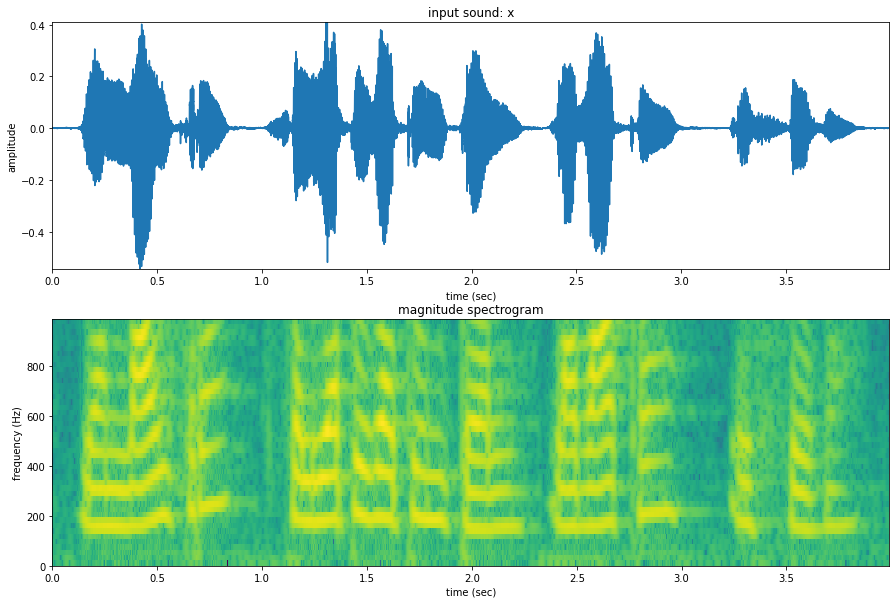

In [119]:
# E7 - 1.1: Set STFT analysis parameters and visualize spectrogram of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### set parameters
window = 'hamming'
M = 2001
N = 2048
H = 128

    
# no need to modify anything after this
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 1000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

In [125]:
# E7 - 1.2: Perform Harmonic plus Stochastic analysis and synthesis of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### fill the parameters
window ='blackman'
M = 1001
N = 2048
t = -80
minSineDur = 0.07
nH = 30
minf0 = 130
maxf0 = 300
f0et = 7
harmDevSlope = 0.02
stocf = 0.2

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=yh, rate=fs))
ipd.display(ipd.Audio(data=yst, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

In [74]:
# E7 - 1.3: Explain the HPS analysis parameters used
'''
window type and window size - for a blackman window with mainlobe width of 6, and min_f0 of 130, if we equate the 
mainlobe width in Hz to 130, we get a window size of about 1000.

FFT size - Set as the next power of two

minimum f0 - The minimum f0 in the spectrogram is ~150. Setting it at 150 misses the lowest parts of the
audio, so a margin of 20 Hz has been taken and it has been set to 130. 

maximum f0 - The maximum f0 in the spectrogram is ~270, so the value has been set to 300 taking a small margin. 

error threshold in f0 detection - Value was decreased iteratively until it started missing parts of the audio

number of harmonics - In the extended spectrogram, a very large number of harmonics could be seen. Considering 
perceptually relevant frequencies to be below 6000 Hz, the number of harmonics is set as 30 such that the highest
harmonic of the average frequency (~200 Hz) is in the 6000 Hz range. 

stochastic decimation factor - Reduced until it started losing clarity in the "s" and "t" sounds. 

'''

'\n\n'

## Part 2. Obtain a good harmonic+stochastic analysis of a monophonic musical phrase

Analyze and synthesize a harmonic sound of your choice from Freesound using the harmonic plus stochastic model. The goal is to obtain the best possible reconstruction using the most compact representation possible. Return an explanation of what you have done and why, together with the re-synthesized sounds.

The sound from freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples. You might also have to select a fragment of the sound.

_Part 2.1:_ Choose a sound from freesound to be analyzed, download it, and if necessary, edit it, and covert it to the right format. It should be a short monophonic musical fragment of a harmonic sound, not longer than 5 seconds. In the explanation add the freesound link of the sound selected and write a brief explanation of why you chose this sound.

_Part 2.2:_ Analyze the chosen sound with the STFT, or with any other analysis or tool you might wish, and describe the characteristics of the sound that will be relevant to perform the harmonic plus stochastic analysis. Important characteristics for the analysis include the pitch range and the maximum number of harmonics. Write no more than a paragraph.

_Part 2.3:_ Select the analysis parameters that give a good reconstruction and at the same time result in to the most compact representation, specially related to the number of harmonic and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. In your descriptions do not use more than one sentence per parameter.

In [ ]:
# E7 - 2.1: download a sound from freesound, read it with waveread, and describe it

#### your code here
input_file = '../sounds/sax-phrase-short.wav'
(fs, x) = UF.wavread(input_file)
ipd.display(ipd.Audio(data=x, rate=fs))

### write a brief description of the sound
"""
A short saxophone phrase where the sound of the wind would be the stochastic component. 

"""

/tmp/ipykernel_47903/1963261998.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))


'\n\nThe sound of the wind is the main stochastic element in the sound. \n'

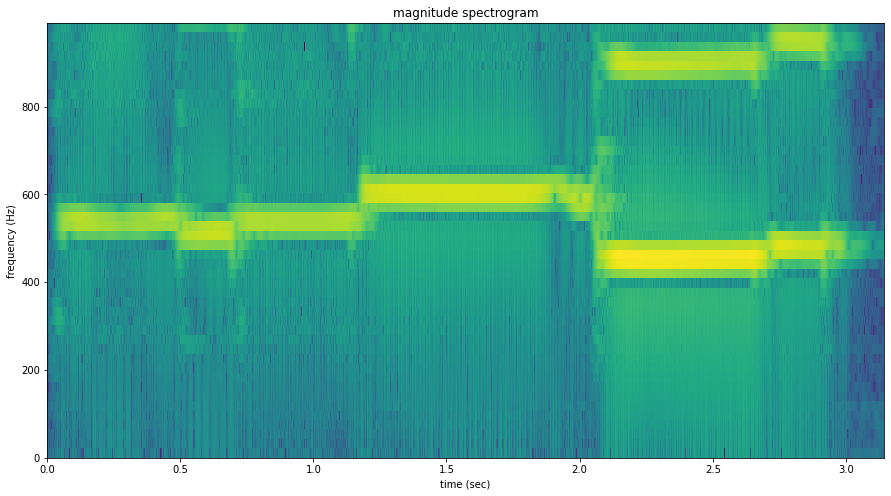

In [149]:
# E7 - 2.2: Set STFT analysis parameters and visualize spectrogram of chosen sound. Explain relevant sound 
# characteristics for HPS model

### basic visualization and listening of sound
input_file = '../sounds/sax-phrase-short.wav'
window = 'hamming'
M = 2001
N = 2048
H = 128

# no need to modify anything after here
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 8))
maxplotfreq = 1000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

### describe the characteristics relevant to perform the harmonic plus stochastic analysis
"""

The sound of the wind is the main stochastic element in the sound. 
"""


In [150]:
# E7 - 2.3: Perform Harmonic plus Stochastic analysis and synthesis of chosen sound


### fill the parameters
input_file = '../sounds/sax-phrase-short.wav'
window ='hamming'
M = 401
N = 512
t = -80
minSineDur = 0.1
nH = 15 
minf0 = 420
maxf0 = 620
f0et = 9
harmDevSlope = 0.02
stocf = 0.1

# No need to modify
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

In [ ]:
# E7 - 2.4: Explain the choices of HPS analysis parameters
'''
window type and window size - for a hamming window with mainlobe width of 4, and min_f0 of 450, if we equate the 
mainlobe width in Hz to 450, we get a window size of about 400.

FFT size - Set as the next power of two

minimum f0 - The minimum f0 in the spectrogram is ~450. Adding a margin, the value is set to 420.  

maximum f0 - The maximum f0 in the spectrogram is ~600. Adding a margin, the value is set to 620. 

error threshold in f0 detection - Value was decreased iteratively until it started missing parts of the audio

number of harmonics - the highest note has it's 15th harmonic at around 6 KHz, so the value has been set to 15. 

stochastic decimation factor - set to the lowest value possible without losing clarity 


'''